In [280]:
import collections
# Prepare paths to local utilities
import os
import sys

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [281]:

is_kaggle = (os.environ.get("PWD", "") == "/kaggle/working")
print(f"Are we running in Kaggle? {is_kaggle}")

Are we running in Kaggle? False


In [282]:
if not is_kaggle:
    models_path = os.path.abspath(os.path.join('..', 'model'))
    utils_path = os.path.abspath(os.path.join('..', 'util'))
    sys.path.append(models_path)
    sys.path.append(utils_path)

    %load_ext autoreload
    %autoreload 2

    from download.DataDownloader import DataDownloader
    from collect.DataframeCollector import DataframeCollector
    from collect.TestSetSplitter import TestSetSplitter
    from collect.BinnedTestSetSplitter import BinnedTestSetSplitter
    from reservoir.BasicESNCuda import BasicESNCuda as BasicESN
    from reservoir.ESNUtil import generate_input_weights

else:
    from datadownloader.datadownloader import DataDownloader
    from dataframecollector.dataframecollector import DataframeCollector
    from testsetsplitter.testsetsplitter import TestSetSplitter
    from binnedtestsetsplitter.binnedtestsetsplitter import BinnedTestSetSplitter
    from basicesncuda.basicesncuda import BasicESNCuda as BasicESN
    from esnutil.esnutil import generate_input_weights

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [283]:
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
import contextlib


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    '''
    Context manager to patch joblib to report into tqdm progress bar given as argument
    :param tqdm_object: The tqdm progress bar
    '''

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback

    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()


In [284]:
if is_kaggle:
    data_path = '/kaggle/input/har70'
else:
    data_path = os.path.abspath(os.path.join('..', 'data'))

In [285]:
if not is_kaggle:
    # Download data
    downloader = DataDownloader()
    downloader.download_data('har70plus', data_path)

Dataset already downloaded


In [286]:
# Collect data into dataframes
collector = DataframeCollector()
collector.load_full_dataset(data_path + '/har70plus')

Discovered  18  csv files in  E:\PyCharm\COM6906-Dissertation\data/har70plus
Loading the csv files into dataframes
Loaded  18  dataframes
Concatenating the dataframes


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,record_num
0,2021-03-24 14:42:03.839,-0.999023,-0.063477,0.140625,-0.980469,-0.112061,-0.048096,6,0
1,2021-03-24 14:42:03.859,-0.980225,-0.079346,0.140625,-0.961182,-0.121582,-0.051758,6,1
2,2021-03-24 14:42:03.880,-0.950195,-0.076416,0.140625,-0.949463,-0.080566,-0.067139,6,2
3,2021-03-24 14:42:03.900,-0.954834,-0.059082,0.140381,-0.957520,-0.046143,-0.050781,6,3
4,2021-03-24 14:42:03.920,-0.972412,-0.042969,0.142822,-0.977051,-0.023682,-0.026611,6,4
...,...,...,...,...,...,...,...,...,...
2259592,2021-06-11 11:13:14.098,-0.960693,-0.199951,-0.330566,-0.977051,0.006104,-0.246826,1,2259592
2259593,2021-06-11 11:13:14.118,-0.942627,-0.210205,-0.331543,-0.969482,0.004883,-0.231445,1,2259593
2259594,2021-06-11 11:13:14.138,-0.907227,-0.190918,-0.320312,-1.048096,0.067627,-0.234375,1,2259594
2259595,2021-06-11 11:13:14.159,-0.883057,-0.156982,-0.311279,-1.007080,0.063965,-0.248047,1,2259595


In [287]:
test_split = 0.2
train_split = 1 - test_split
validation_split = 0.2

In [288]:
from sklearn.model_selection import train_test_split

dataset = collector.get_collected_data()

# The features are in the 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z' columns
features = dataset[['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z','record_num','timestamp']]
labels = dataset['label']

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=test_split, random_state=42, stratify=labels)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=validation_split, random_state=42, stratify=y_train)

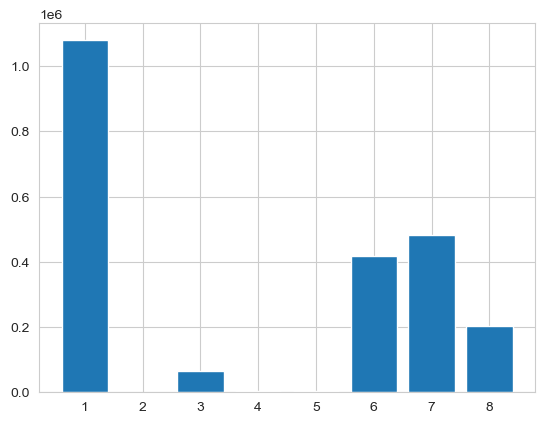

In [289]:
# Plot the distribution of the labels
label_counts = collections.Counter(labels)

plt.bar(label_counts.keys(), label_counts.values())

plt.show()

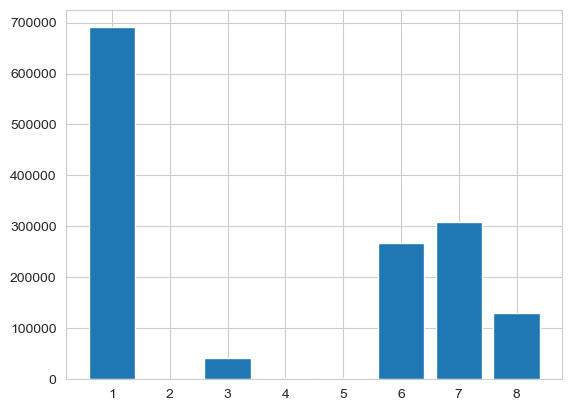

In [290]:
# Plot the distribution of the labels in the training set
label_counts = collections.Counter(y_train)

plt.bar(label_counts.keys(), label_counts.values())

plt.show()

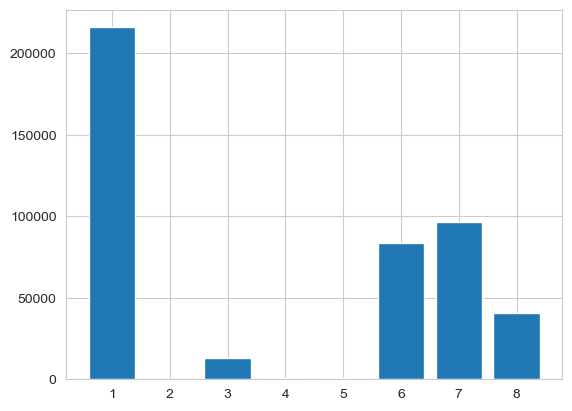

In [291]:
# Plot the distribution of the labels in the test set
label_counts = collections.Counter(y_test)

plt.bar(label_counts.keys(), label_counts.values())

plt.show()

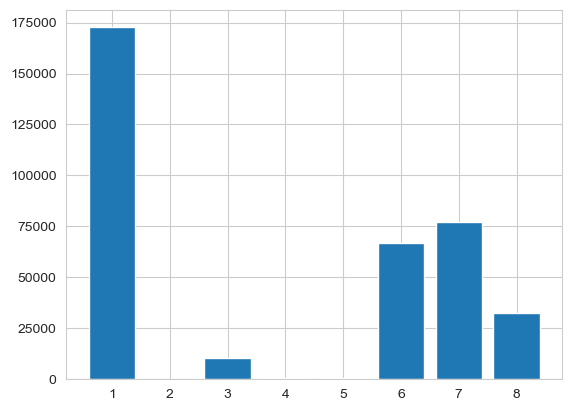

In [292]:
# Plot the distribution of the labels in the validation set
label_counts = collections.Counter(y_val)

plt.bar(label_counts.keys(), label_counts.values())

plt.show()

In [293]:
# Get the number of each label in each set
train_label_counts = collections.Counter(y_train)
test_label_counts = collections.Counter(y_test)
val_label_counts = collections.Counter(y_val)

print(f"Train label counts: {train_label_counts}")
print(f"Test label counts: {test_label_counts}")
print(f"Validation label counts: {val_label_counts}")

Train label counts: Counter({1: 690759, 7: 309409, 6: 267555, 8: 130037, 3: 42277, 5: 3186, 4: 2918})
Test label counts: Counter({1: 215863, 7: 96690, 6: 83611, 8: 40636, 3: 13212, 5: 996, 4: 912})
Validation label counts: Counter({1: 172690, 7: 77353, 6: 66889, 8: 32509, 3: 10569, 5: 796, 4: 730})


In [294]:
# Calculate a ratio of the number of each label in each set
train_label_ratios = {label: count / len(y_train) for label, count in train_label_counts.items()}
test_label_ratios = {label: count / len(y_test) for label, count in test_label_counts.items()}
val_label_ratios = {label: count / len(y_val) for label, count in val_label_counts.items()}

# Sort the ratios by label
train_label_ratios = dict(sorted(train_label_ratios.items()))
test_label_ratios = dict(sorted(test_label_ratios.items()))
val_label_ratios = dict(sorted(val_label_ratios.items()))

print(f"Train label ratios: {train_label_ratios}")
print(f"Test label ratios: {test_label_ratios}")
print(f"Validation label ratios: {val_label_ratios}")

Train label ratios: {1: 0.4776567430146853, 3: 0.029234355432838154, 4: 0.002017783881378095, 5: 0.0022031046765149456, 6: 0.18501307963746275, 7: 0.21395493247200653, 8: 0.08992000088511425}
Test label ratios: {1: 0.47765755000885113, 3: 0.029235262878385553, 4: 0.00201805629314923, 5: 0.0022039298990971855, 6: 0.1850128341299345, 7: 0.2139537971322358, 8: 0.0899185696583466}
Validation label ratios: {1: 0.47765644361833953, 3: 0.029233603292618163, 4: 0.002019162683660825, 5: 0.002201717118073995, 6: 0.1850133873251903, 7: 0.21395656310851477, 8: 0.0899191228536024}


In [295]:
# Lets check the order of the columns in the features dataframe
features.columns

Index(['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z',
       'record_num', 'timestamp'],
      dtype='object')

In [296]:
splitter = BinnedTestSetSplitter(test_size=test_split, val_size=validation_split, seed=42)

splitter.generate_splits(features, labels)

x_train, y_train, x_val, y_val, x_test, y_test = splitter.get_splits()

Chunks shape:  (17654, 128, 8)
Data shape:  (17654, 1024) (17654, 128)


In [297]:
# The data has been converted to numpy arrays, so we need to convert it back to dataframes
x_train = pd.DataFrame(x_train, columns=['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z','record_num','timestamp'])
x_val = pd.DataFrame(x_val, columns=['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z','record_num','timestamp'])
x_test = pd.DataFrame(x_test, columns=['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z','record_num','timestamp'])

y_train = pd.Series(y_train, name='label')
y_val = pd.Series(y_val, name='label')
y_test = pd.Series(y_test, name='label')

In [298]:
# Grab the first 5 rows of the training set
x_train.head()

,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,record_num,timestamp
0,-0.970947,0.059082,-0.119873,-0.979004,-0.115967,-0.032227,420352,2021-04-07 10:38:28.899
1,-0.961182,0.066162,-0.090576,-0.97168,-0.058838,-0.04834,420353,2021-04-07 10:38:28.920
2,-0.946289,0.056885,-0.06543,-0.922119,-0.001465,-0.049072,420354,2021-04-07 10:38:28.940
3,-0.92041,0.027344,-0.068115,-0.987549,-0.046631,-0.068604,420355,2021-04-07 10:38:28.959
4,-0.885254,0.005127,-0.035645,-1.022949,-0.195557,-0.112549,420356,2021-04-07 10:38:28.979


In [304]:
x_train.describe()

,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,record_num,timestamp
count,1446144.0,1446144.0,1.446144e+06,1.446144e+06,1446144.0,1.446144e+06,1446144,1446144
unique,8877.0,6474.0,8.741000e+03,1.770800e+04,15203.0,1.647000e+04,1446144,1446144
top,-1.0,0.0,8.906250e-01,-9.687500e-01,0.0,-1.078125e+00,0,2021-03-24 14:42:03.839
freq,36004.0,19602.0,1.495800e+04,3.895800e+04,15198.0,3.666300e+04,1,1


In [299]:
# Get the number of each label in each set
train_label_counts = collections.Counter(y_train)
test_label_counts = collections.Counter(y_test)
val_label_counts = collections.Counter(y_val)

print(f"Train label counts: {train_label_counts}")
print(f"Test label counts: {test_label_counts}")
print(f"Validation label counts: {val_label_counts}")

Train label counts: Counter({1.0: 692045, 7.0: 309107, 6.0: 266823, 8.0: 129880, 3.0: 42260, 5.0: 3393, 4.0: 2636})
Test label counts: Counter({1.0: 215637, 7.0: 96827, 6.0: 83600, 8.0: 40653, 3.0: 13244, 4.0: 1078, 5.0: 929})
Validation label counts: Counter({1.0: 171630, 7.0: 77518, 6.0: 67632, 8.0: 32649, 3.0: 10554, 4.0: 846, 5.0: 656, 0.0: 115})


In [300]:
# Calculate a ratio of the number of each label in each set
train_label_ratios = {label: count / len(y_train) for label, count in train_label_counts.items()}
test_label_ratios = {label: count / len(y_test) for label, count in test_label_counts.items()}
val_label_ratios = {label: count / len(y_val) for label, count in val_label_counts.items()}

# Sort the ratios by label
train_label_ratios = dict(sorted(train_label_ratios.items()))
test_label_ratios = dict(sorted(test_label_ratios.items()))
val_label_ratios = dict(sorted(val_label_ratios.items()))

print(f"Train label ratios: {train_label_ratios}")
print(f"Test label ratios: {test_label_ratios}")
print(f"Validation label ratios: {val_label_ratios}")

Train label ratios: {1.0: 0.47854501349796424, 3.0: 0.029222539387502213, 4.0: 0.0018227783678527172, 5.0: 0.0023462393786510887, 6.0: 0.18450652217206584, 7.0: 0.213745657417242, 8.0: 0.0898112497787219}
Test label ratios: {1.0: 0.4771067863211555, 3.0: 0.029302959501557632, 4.0: 0.0023851246105919, 5.0: 0.0020554552534692723, 6.0: 0.18496884735202493, 7.0: 0.21423419357122628, 8.0: 0.08994663338997451}
Validation label ratios: {0.0: 0.00031803097345132743, 1.0: 0.4746404867256637, 3.0: 0.029186946902654866, 4.0: 0.0023396017699115045, 5.0: 0.0018141592920353983, 6.0: 0.1870353982300885, 7.0: 0.214375, 8.0: 0.09029037610619468}


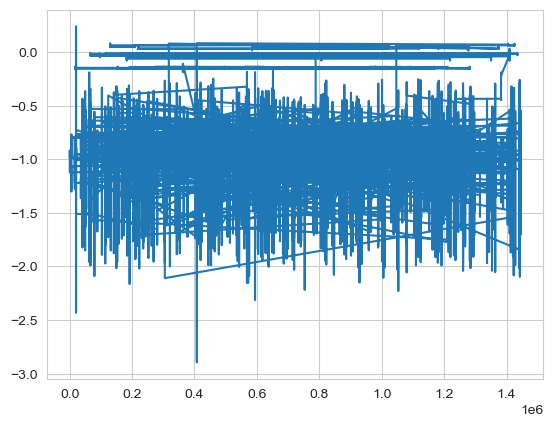

In [301]:
# We may need to re-sort the dataframes by record_num
x_train = x_train.sort_values('record_num')
y_train = y_train.loc[x_train.index]

x_val = x_val.sort_values('record_num')
y_val = y_val.loc[x_val.index]

x_test = x_test.sort_values('record_num')
y_test = y_test.loc[x_test.index]

#Plot the training set in order to check that the temporal order is preserved
# Max of 100000 samples to avoid memory issues
# Only plot back_x too
plt.plot(x_train['back_x'][:100000])

In [302]:
# The records are out of order, we need to make sure that they are ordered by record_num
x_train = x_train.sort_values('record_num')

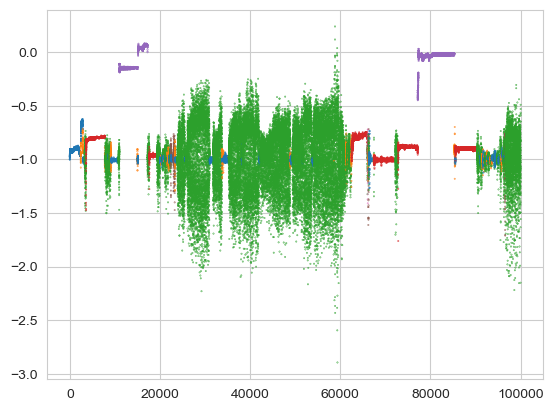

In [303]:
# Let's plot the training set, but colour each label differently
# Max of 100000 samples to avoid memory issues

# Get the unique labels
unique_labels = y_train.unique()

# Create a dictionary to map each label to a colour
label_colour_map = {label: f"C{i}" for i, label in enumerate(unique_labels)}

# Create a list of colours for each label
label_colours = [label_colour_map[label] for label in y_train]

plt.scatter(range(100000), x_train['back_x'][:100000], c=label_colours[:100000], s=0.1)


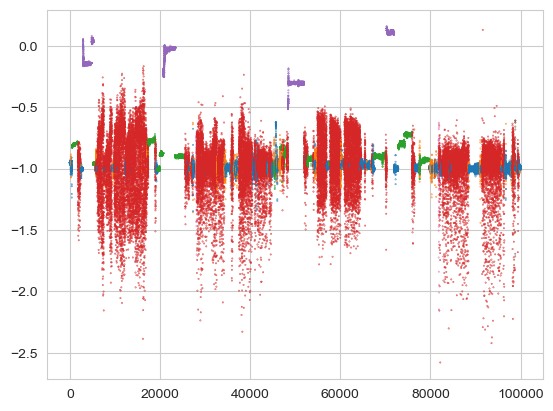

In [305]:
# Let's plot the test set, but colour each label differently
# Max of 100000 samples to avoid memory issues

# Get the unique labels
unique_labels = y_test.unique()

# Create a dictionary to map each label to a colour
label_colour_map = {label: f"C{i}" for i, label in enumerate(unique_labels)}

# Create a list of colours for each label
label_colours = [label_colour_map[label] for label in y_test]

plt.scatter(range(100000), x_test['back_x'][:100000], c=label_colours[:100000], s=0.1)